In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the dataset
df = pd.read_csv(r"C:\Users\adilp\Downloads\INFY Historical Data (2).csv")



In [3]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

In [4]:
# Clean numeric columns
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

In [5]:
# Convert Volume
def parse_volume(vol):
    if 'M' in vol:
        return float(vol.replace('M', '').replace(',', '')) * 1_000_000
    elif 'K' in vol:
        return float(vol.replace('K', '').replace(',', '')) * 1_000
    else:
        return float(vol.replace(',', ''))
df['Vol.'] = df['Vol.'].apply(parse_volume)

In [6]:
# Clean Change %
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)


In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [29]:
df['Price']

1084    1260.45
1083    1288.25
1082    1293.80
1081    1282.10
1080    1262.15
         ...   
4       1592.40
3       1613.00
2       1589.90
1       1559.80
0       1560.60
Name: Price, Length: 1085, dtype: float64

In [116]:
df_model = df[['Date', 'Price']].copy()
n=5
for lag in range(1, n+1):
    df_model[f'lag_{lag}'] = df_model['Price'].shift(lag)
    #print(df_model['Price'].shift(lag))
df_model.dropna(inplace=True)

In [43]:
df['Price']

1084    1260.45
1083    1288.25
1082    1293.80
1081    1282.10
1080    1262.15
         ...   
4       1592.40
3       1613.00
2       1589.90
1       1559.80
0       1560.60
Name: Price, Length: 1085, dtype: float64

In [118]:
# 2. Create X and y
X = df_model[[f'lag_{i}' for i in range(1, n+1)]]
y = df_model['Price']

In [120]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5
1079,1262.15,1282.10,1293.80,1288.25,1260.45
1078,1312.10,1262.15,1282.10,1293.80,1288.25
1077,1376.20,1312.10,1262.15,1282.10,1293.80
1076,1371.75,1376.20,1312.10,1262.15,1282.10
1075,1387.15,1371.75,1376.20,1312.10,1262.15
...,...,...,...,...,...
4,1568.60,1626.90,1507.60,1511.40,1508.30
3,1592.40,1568.60,1626.90,1507.60,1511.40
2,1613.00,1592.40,1568.60,1626.90,1507.60
1,1589.90,1613.00,1592.40,1568.60,1626.90


In [122]:
# 3. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [124]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [126]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 3043.79


In [128]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.8762


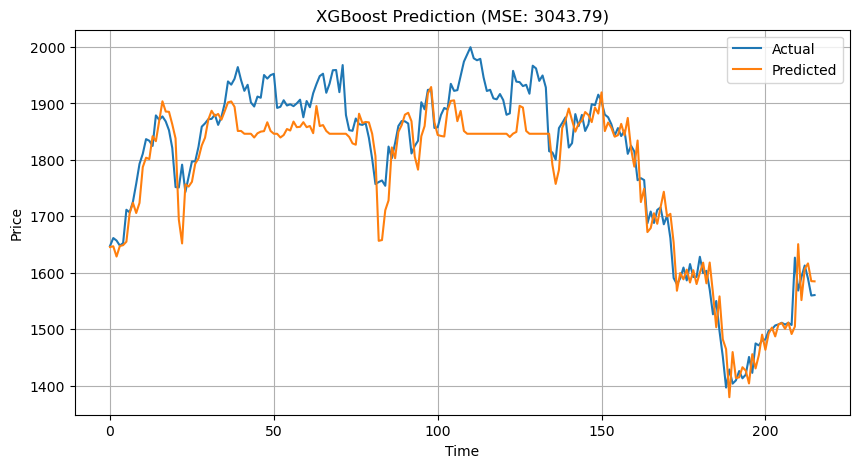

In [130]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f'XGBoost Prediction (MSE: {mse:.2f})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
# Forecast next 7 days
last_known = X.iloc[-1].values.reshape(1, -1)
future_preds = []

for _ in range(7):
    next_pred = model.predict(last_known)[0]
    future_preds.append(next_pred)
    #print(future_preds)
    last_known = np.roll(last_known, -1)
    print(np.roll(last_known, -1))
    last_known[0, -1] = next_pred

print("Forecast for next 7 days:", future_preds)


[[1613.  1592.4 1568.6 1559.8 1589.9]]
[[1592.4        1568.6        1584.92028809 1589.9        1613.        ]]
[[1568.6        1584.92028809 1585.9732666  1613.         1592.4       ]]
[[1584.92028809 1585.9732666  1610.15429688 1592.4        1568.6       ]]
[[1585.9732666  1610.15429688 1594.79345703 1568.6        1584.92028809]]
[[1610.15429688 1594.79345703 1557.88806152 1584.92028809 1585.9732666 ]]
[[1594.79345703 1557.88806152 1588.82824707 1585.9732666  1610.15429688]]
Forecast for next 7 days: [1584.9203, 1585.9733, 1610.1543, 1594.7935, 1557.8881, 1588.8282, 1570.9785]


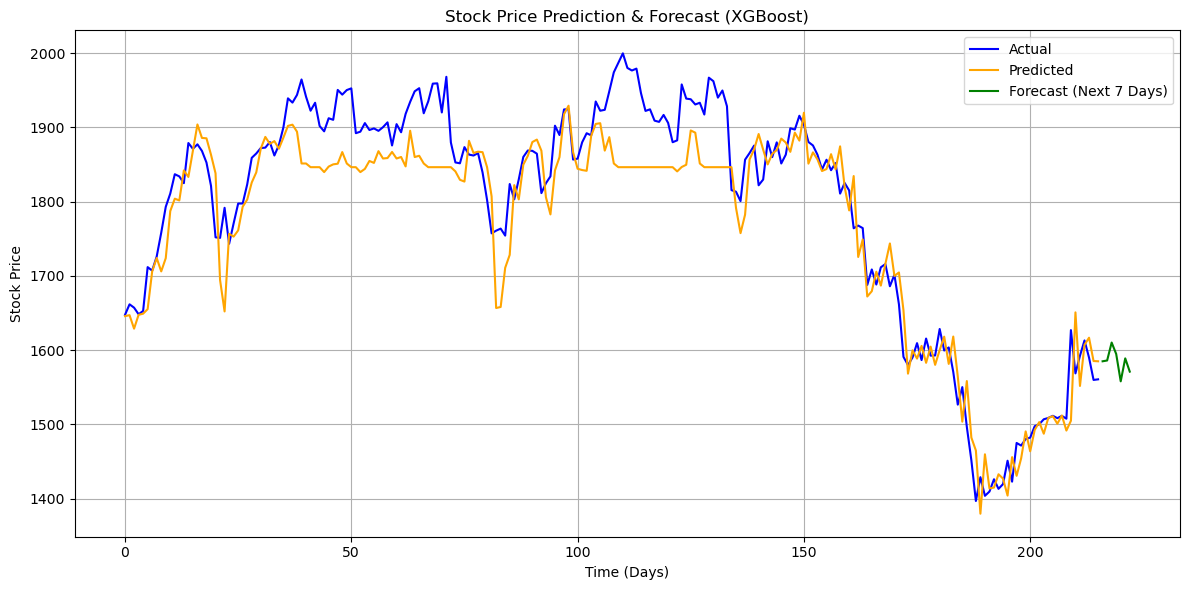

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Forecast next 7 days
last_known = X.iloc[-1].values.reshape(1, -1)
future_preds = []

for _ in range(7):
    next_pred = model.predict(last_known)[0]
    future_preds.append(next_pred)
    last_known = np.roll(last_known, -1)
    last_known[0, -1] = next_pred

# Step 2: Plot actual, predicted, and forecast
plt.figure(figsize=(12, 6))

# Actual values from test set
plt.plot(range(len(y_test)), y_test.values, label='Actual', color='blue')

# Predicted values from model
plt.plot(range(len(y_test)), y_pred, label='Predicted', color='orange')

# Forecasted values (next 7 days)
forecast_range = range(len(y_test), len(y_test) + 7)
plt.plot(forecast_range, future_preds, label='Forecast (Next 7 Days)', color='green')

# Styling
plt.title("Stock Price Prediction & Forecast (XGBoost)")
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
